In [ ]:

from scipy.stats import t, norm

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.optimizers.legacy import Optimizer
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

import pickle


In [ ]:
data = pd.read_csv('Indian ATM preprocessed.csv')
data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.420395,-0.304479,0.120964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,503400.0
1,-1.296688,-1.199232,-1.463074,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,123800.0
2,-0.858541,-1.074961,-0.911767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,287700.0
3,2.628376,2.255508,1.078115,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,945300.0
4,2.409303,-0.031083,-0.276599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,767900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,-0.402139,0.093189,0.346663,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,498300.0
12671,-0.055272,-0.602730,-0.102665,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,544800.0
12672,0.547179,-0.329333,-0.135278,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,608600.0
12673,0.072520,0.267168,1.646505,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,902500.0


In [ ]:
tr = int(len(data) * 0.8)

X, y = data.iloc[:, :32], data.iloc[:, 32]

X_train, X_test = X[:tr], X[tr:]
y_train, y_test = y[:tr], y[tr:]

In [ ]:
y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_test_normalized = (y_test - y_mean) / y_std
y_train_normalized = (y_train - y_mean) / y_std

In [ ]:
# hyperparameters for Tube Loss

q = 0.95 # target coverage

def confidence_loss(y_true, y_pred):

    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) + (delta * tf.abs(f1 - f2))

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)


In [ ]:
#set up model call the Tube loss with r=0.1
n_ = 64 # batch size

model = Sequential([

        Dense(64, input_dim = X_train.shape[1], activation='relu',
        kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2),
        kernel_regularizer=l2(1e-4)),

        BatchNormalization(),
        Dense(128, input_dim = X_train.shape[1], activation='relu',
        kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2),
        kernel_regularizer=l2(1e-4)),
        Dropout(0.25),

        Dense(32, input_dim = X_train.shape[1], activation='relu',
        kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2),
        kernel_regularizer=l2(1e-4)),
        Dropout(0.25),

        Dense(2, activation='linear',
        kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
        bias_initializer=keras.initializers.Constant(value=[-3,3])) # important to init biases to start!
])


opt = keras.optimizers.Adam(learning_rate=0.001)

# Use the Tube loss with r and delta parameter.
delta = 0.025
r = 0.5
loss=confidence_loss
model.compile(loss=loss, optimizer=opt, metrics=['mae'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,882 (58.13 KB)

 Trainable params: 14,754 (57.63 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Train the ANN with Tube loss
history = model.fit(X_train, y_train_normalized,
                    epochs=500, batch_size=n_, verbose=1,
                    validation_data=(X_test, y_test_normalized),)

Epoch 1/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9678 - mae: 4.4153 - val_loss: 0.2989 - val_mae: 1.3322
Epoch 2/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4127 - mae: 2.9182 - val_loss: 0.2014 - val_mae: 1.4733
Epoch 3/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3466 - mae: 2.4321 - val_loss: 0.1982 - val_mae: 1.6088
Epoch 4/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3027 - mae: 2.0722 - val_loss: 0.1922 - val_mae: 1.6410
Epoch 5/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2794 - mae: 1.9151 - val_loss: 0.1807 - val_mae: 1.5320
Epoch 6/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2627 - mae: 1.7574 - val_loss: 0.1682 - val_mae: 1.4040
Epoch 7/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2451 - mae: 1.6628 - val_loss: 0.1542 - val_mae: 1.2507
Epoch 8/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2302 - mae: 1.5055 - val_loss: 0.1547 - val_mae: 1.3714
Epoch 9/500
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [ ]:
model.save('TUBE.keras')
model.save('TUBE.h5')

with open('TUBE', 'wb') as file:

    pickle.dump(model, file)

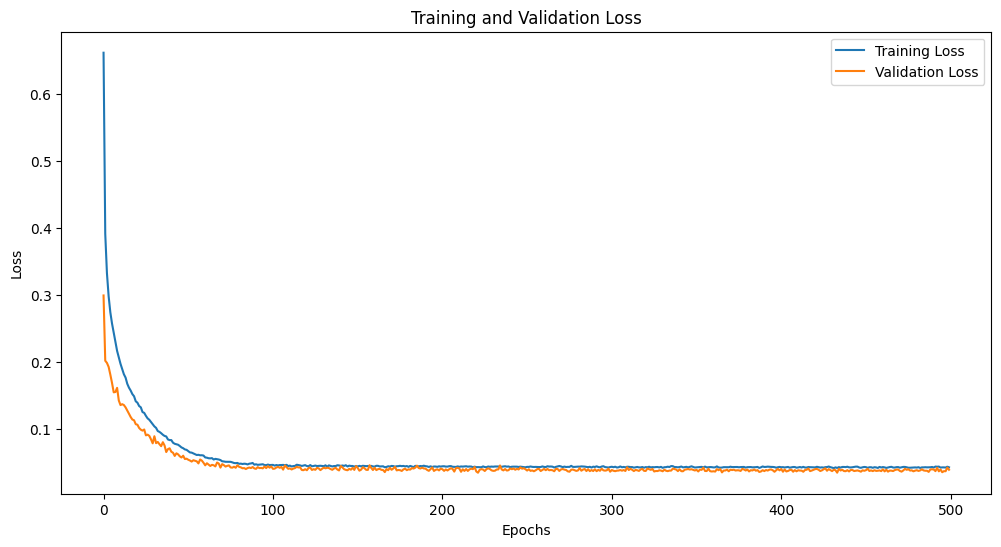

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# plot and view some predictions
y_pred = model.predict(X_test, verbose=0)

y_pred_denorm = y_pred * y_std + y_mean

upper_bound = y_pred_denorm[:,0].flatten()
lower_bound = y_pred_denorm[:,1].flatten()
mean_pred = (upper_bound + lower_bound) / 2

outcome = (y_test > lower_bound) & (y_test < upper_bound)

outcome = outcome.apply(lambda x: 0 if x ==True else 1)
result = pd.DataFrame({'Original': y_test, 'Predicted': mean_pred,
                        'Lower Bound': lower_bound, 'Upper Bound': upper_bound,
                        # 'Total Error': (upper_bound + lower_bound) / 2 - (y_test),
                      'Outcome': outcome})


result.to_csv(f'Results_TUBE.csv', index=False)


In [ ]:

# Check if true targets fall within the PIs
within_pi = (y_test >= lower_bound) & (y_test <= upper_bound)

# Calculate PICP
PICP = np.mean(within_pi)

# print("\nConfidence Interval: ", PICP)
print("\nPrediction Interval Coverage Probability (PICP):", PICP)

# Calculate the width of the prediction intervals
pi_width = upper_bound - lower_bound

# Calculate MPIW
MPIW = np.mean(pi_width)
print("Mean Prediction Interval Width (MPIW):", MPIW)



Prediction Interval Coverage Probability (PICP): 0.9522682445759368
Mean Prediction Interval Width (MPIW): 187567.97
